## Import Library



In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from sklearn.ensemble import StackingClassifier


In [23]:
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, columns=np.unique(['Negative', 'Positive']), 
                     index = np.unique(['Negative', 'Positive']))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

## Connect Drive and Create data from Json file

In [24]:
# connect google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
# create dataframe
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data Scientist/Final Project/fake_real_COVID_2.csv')

In [26]:
# check null df
df.isna().sum()

Unnamed: 0                0
statement                 2
text                      0
label                     0
languages                 0
target                    0
length                    0
text_without_stopwords    0
lemma                     0
stemming                  0
text_EDA                  0
dtype: int64

In [27]:
# drop columns
df.drop(columns=['Unnamed: 0'], inplace=True)

In [28]:
# drop null value
df = df.dropna()

## TF-IDF

In [50]:

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Fake')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

In [51]:
# split data and vectorizer by tfidf 
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer
    
list_corpus = df["text_EDA"].tolist()
list_labels = df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=42)

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## Calculator model

In [31]:
# model declaration
def Create_models():
  lg = LogisticRegression()
  knc = neighbors.KNeighborsClassifier()
  dt = DecisionTreeClassifier()
  rf = RandomForestClassifier()
  return ((lg,"Logistic Regression"),(knc, "KNC clasifier"),(dt,"Decision Tree Classifier"), (rf, "RandomForest Classifier"))

In [32]:
# Evaluation model
models_Evaluation = Create_models()
for model, name in models_Evaluation:
  model.fit(X_train_tfidf, y_train)
  print(f"Accuracy of {name} on text_EDA: {model.score(X_test_tfidf, y_test)}")

Accuracy of Logistic Regression on text_EDA: 0.8780487804878049
Accuracy of KNC clasifier on text_EDA: 0.8952122854561879
Accuracy of Decision Tree Classifier on text_EDA: 0.8500451671183379
Accuracy of RandomForest Classifier on text_EDA: 0.8970189701897019


## Logistic Regession

In [52]:
# define model LogisticRegression
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
lg_test_pred = lg.predict(X_test_tfidf)

In [53]:
lg_train_predictions_label = lg.predict(X_train_tfidf)
lg_test_predictions_label = lg.predict(X_test_tfidf)

In [54]:
# print score model LogisticRegression
print("Accuracy score on train set: %f" % accuracy_score(y_train, lg_train_predictions_label))
print("Accuracy score on test set: %f" % accuracy_score(y_test, lg_test_predictions_label))

print(classification_report(y_test, lg_test_predictions_label))

Accuracy score on train set: 0.920958
Accuracy score on test set: 0.878049
              precision    recall  f1-score   support

           0       0.94      0.45      0.61       234
           1       0.87      0.99      0.93       873

    accuracy                           0.88      1107
   macro avg       0.90      0.72      0.77      1107
weighted avg       0.89      0.88      0.86      1107



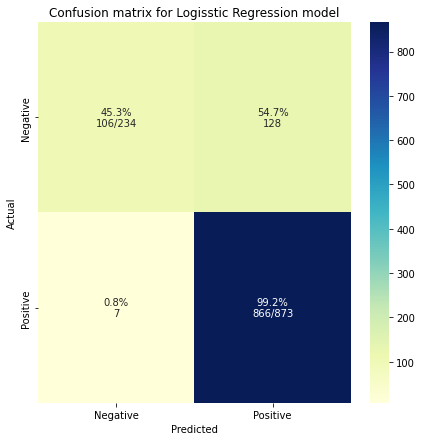

In [55]:
# Showing Confusion Matrix for LG
plot_cm(y_test, lg_test_pred, 'Confusion matrix for Logisstic Regression model', figsize=(7,7))

* we can see model LogisticRegression have 92% accuracy with base model. Now we try Gridsearch LogisticRegression

### GridsearchCV

In [56]:
# Gridsearch LogisticRegression with pipeline
fine_tune_lg = LogisticRegression()
lg_pipeline = Pipeline([
                     ('model',fine_tune_lg)
                     ])
lg_params = {
    'model__C': [1e1,2e1,3e1,4e1,5e1],
    'model__solver': ['lbfgs', 'liblinear'],
    'model__multi_class': ['multinomial','auto'],
    'model__random_state': [17],
    'model__n_jobs': [4]

}
gslg = GridSearchCV(lg_pipeline,lg_params,scoring='f1',cv=KFold(n_splits=5,shuffle=True,random_state=42))
gslg.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random

In [57]:
# best_params_ Logistic Regression
gslg.best_params_

{'model__C': 50.0,
 'model__multi_class': 'multinomial',
 'model__n_jobs': 4,
 'model__random_state': 17,
 'model__solver': 'lbfgs'}

In [58]:
gslg_train_predictions_label = gslg.predict(X_train_tfidf)
gslg_test_predictions_label = gslg.predict(X_test_tfidf)
lg_best_estimator = gslg.best_estimator_.predict(X_test_tfidf)

In [59]:
print("Accuracy score on train set: %f" % accuracy_score(y_train, gslg_train_predictions_label))
print("Accuracy score on test set: %f" % accuracy_score(y_test, gslg_test_predictions_label))

print(classification_report(y_test, lg_best_estimator))

Accuracy score on train set: 0.999548
Accuracy score on test set: 0.928636
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       234
           1       0.94      0.98      0.96       873

    accuracy                           0.93      1107
   macro avg       0.92      0.86      0.89      1107
weighted avg       0.93      0.93      0.93      1107



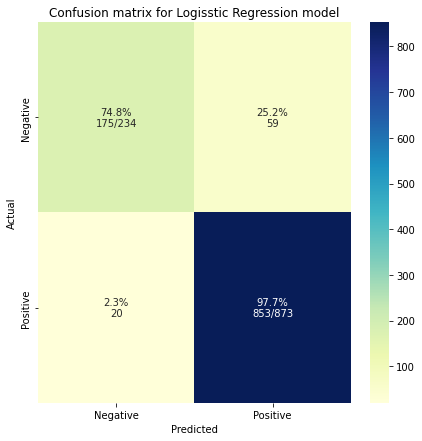

In [60]:
plot_cm(y_test, lg_best_estimator, 'Confusion matrix for Logisstic Regression model', figsize=(7,7))

* After Gridsearch, LogisticRegression model have 93% accuracy

## KNC

In [61]:
# define model KNeighborsClassifier
knc = neighbors.KNeighborsClassifier()
knc_tfidf = knc.fit(X_train_tfidf, y_train)
knc_pred = knc.predict(X_test_tfidf)

In [62]:

knc_train_predictions_label = knc.predict(X_train_tfidf)
knc_predictions_label = knc.predict(X_test_tfidf)

In [63]:
# print score KNeighborsClassifier
print("Accuracy score on train set: %f" % accuracy_score(y_train, knc_train_predictions_label))
print("Accuracy score on test set: %f" % accuracy_score(y_test, knc_predictions_label))

print(classification_report(y_test, knc_pred))

Accuracy score on train set: 0.934734
Accuracy score on test set: 0.895212
              precision    recall  f1-score   support

           0       0.87      0.59      0.71       234
           1       0.90      0.98      0.94       873

    accuracy                           0.90      1107
   macro avg       0.88      0.78      0.82      1107
weighted avg       0.89      0.90      0.89      1107



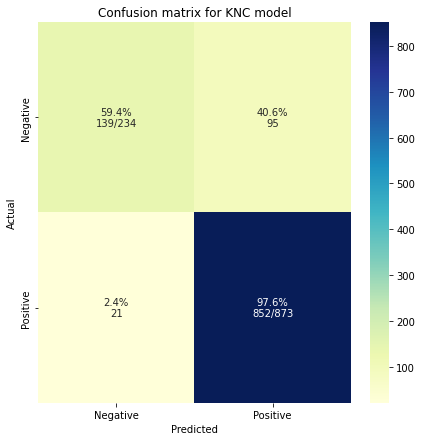

In [64]:
# Showing Confusion Matrix for KNC model
plot_cm(y_test, knc_pred, 'Confusion matrix for KNC model', figsize=(7,7))

* model KNeighborsClassifier have 87% accuracy with base model. Now we try Gridsearch KNeighborsClassifier

### GridsearchCV

In [65]:
# define model KNeighborsClassifier with pipeline
fine_tune_knc = KNeighborsClassifier()
knc_pipeline = Pipeline([
                     ('model',fine_tune_knc)
                     ])
knc_params = {
    'model__n_neighbors': [11,12,13,14,15],
    'model__weights': ['uniform','distance'],
    'model__metric': ['minkowski', 'chebyshev'],
    'model__p': [2,3,4,5,6,7,8,9,10],
    'model__algorithm': ['ball_tree','auto','kd_tree','brute']
}
gsknc = GridSearchCV(knc_pipeline,knc_params,scoring='f1',cv=KFold(n_splits=5,shuffle=True,random_state=42))

In [66]:
gsknc.fit(X_train_tfidf, y_train)

Streaming output truncated to the last 5000 lines.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:414: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Metric 'chebyshev' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:414: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The scor

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'model__algorithm': ['ball_tree', 'auto', 'kd_tree',
                                              'brute'],
                         'mode

In [67]:
# best_params_ KNeighborsClassifier
gsknc.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'minkowski',
 'model__n_neighbors': 12,
 'model__p': 2,
 'model__weights': 'distance'}

In [68]:
gsknc_train_predictions_label = gsknc.predict(X_train_tfidf)
gsknc_test_predictions_label = gsknc.predict(X_test_tfidf)
knc_best_estimator = gsknc.best_estimator_.predict(X_test_tfidf)

In [69]:
# print score KNeighborsClassifier again
print("Accuracy score on train set: %f" % accuracy_score(y_train, gsknc_train_predictions_label))
print("Accuracy score on test set: %f" % accuracy_score(y_test, gsknc_test_predictions_label))

print(classification_report(y_test, knc_best_estimator))

Accuracy score on train set: 0.999548
Accuracy score on test set: 0.893406
              precision    recall  f1-score   support

           0       0.90      0.56      0.69       234
           1       0.89      0.98      0.94       873

    accuracy                           0.89      1107
   macro avg       0.90      0.77      0.81      1107
weighted avg       0.89      0.89      0.88      1107



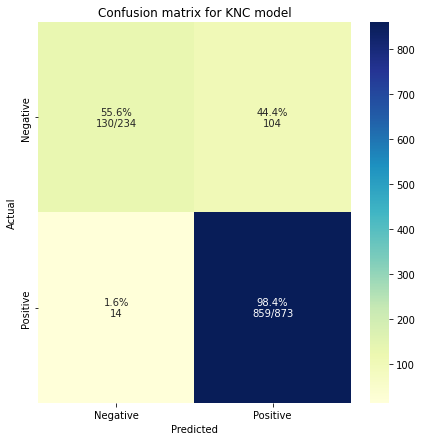

In [70]:
# Showing Confusion Matrix for KNC model
plot_cm(y_test, knc_best_estimator, 'Confusion matrix for KNC model', figsize=(7,7))

* After Gridsearch, KNeighborsClassifier model have 89% accuracy

## SVC

In [71]:
# define model SupportVectorClassifier
svc = svm.SVC()
svc_tfidf = svc.fit(X_train_tfidf, y_train)
svc_pred = svc.predict(X_test_tfidf)

In [72]:
svc_train_predictions_label = svc.predict(X_train_tfidf)
svc_test_predictions_label = svc.predict(X_test_tfidf)

In [73]:
# prin score SupportVectorClassifier
print("Accuracy score on train set: %f" % accuracy_score(y_train, svc_train_predictions_label))
print("Accuracy score on test set: %f" % accuracy_score(y_test, svc_test_predictions_label))

print(classification_report(y_test, svc_pred))

Accuracy score on train set: 0.992096
Accuracy score on test set: 0.903342
              precision    recall  f1-score   support

           0       0.96      0.56      0.71       234
           1       0.89      0.99      0.94       873

    accuracy                           0.90      1107
   macro avg       0.93      0.78      0.83      1107
weighted avg       0.91      0.90      0.89      1107



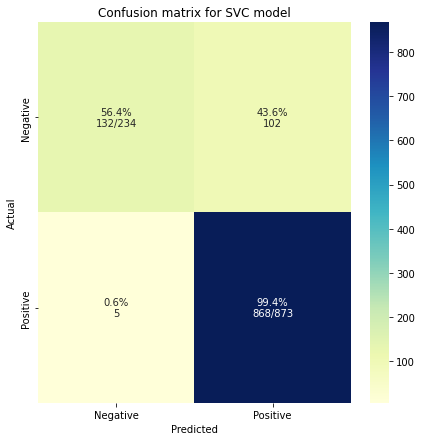

In [74]:
# Showing Confusion Matrix for SVC model
plot_cm(y_test, svc_pred, 'Confusion matrix for SVC model', figsize=(7,7))

* model SupportVectorClassifier have 90% accuracy with base model. Now we try Gridsearch SupportVectorClassifier

### GridsearchCV

In [75]:
# define model SupportVectorClassifier with pipeline
fine_tune_svc = svm.SVC()
svc_pipeline = Pipeline([
                     ('model',fine_tune_svc)
                     ])
svc_params = {
    'model__C': np.arange(1, 10, 10),
    'model__gamma': ['scale', 'auto']
}
gssvc = GridSearchCV(svc_pipeline,svc_params,scoring='f1',cv=KFold(n_splits=5,shuffle=True,random_state=42))

In [76]:
gssvc.fit(X_train_tfidf, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'model__C': array([1]),
                         'model__gam

In [77]:
# best_params_ SupportVectorClassifier
gssvc.best_params_

{'model__C': 1, 'model__gamma': 'scale'}

In [78]:
gssvc_train_predictions_label = gssvc.predict(X_train_tfidf)
gssvc_test_predictions_label = gssvc.predict(X_test_tfidf)
svc_best_estimator = gssvc.best_estimator_.predict(X_test_tfidf)

In [79]:
# print score SupportVectorClassifier after gridsearch
print("Accuracy score on train set: %f" % accuracy_score(y_train, gssvc_train_predictions_label))
print("Accuracy score on test set: %f" % accuracy_score(y_test, gssvc_test_predictions_label))

print(classification_report(y_test, svc_best_estimator))

Accuracy score on train set: 0.992096
Accuracy score on test set: 0.903342
              precision    recall  f1-score   support

           0       0.96      0.56      0.71       234
           1       0.89      0.99      0.94       873

    accuracy                           0.90      1107
   macro avg       0.93      0.78      0.83      1107
weighted avg       0.91      0.90      0.89      1107



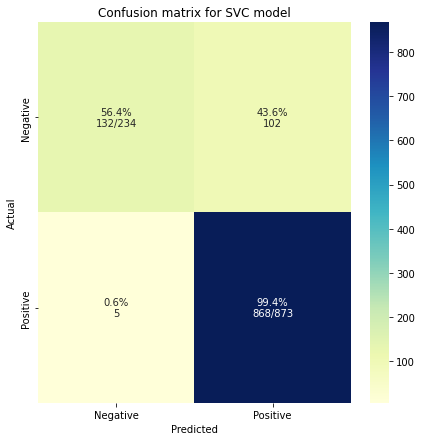

In [80]:
# Showing Confusion Matrix for SVC model
plot_cm(y_test, svc_best_estimator, 'Confusion matrix for SVC model', figsize=(7,7))

* After Gridsearch, SupportVectorClassifier model have 90% accuracy

## Random Forest

In [81]:
# define model RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
y_rf_pred = rf.predict(X_test_tfidf)

In [82]:
rf_train_predictions_label = rf.predict(X_train_tfidf)
rf_predictions_label = rf.predict(X_test_tfidf)

In [83]:
# print score RandomForestClassifier
print("Accuracy score on train set: %f" % accuracy_score(y_train, rf_train_predictions_label))
print("Accuracy score on test set: %f" % accuracy_score(y_test, rf_predictions_label))

print(classification_report(y_test,y_rf_pred))

Accuracy score on train set: 0.999548
Accuracy score on test set: 0.892502
              precision    recall  f1-score   support

           0       0.95      0.52      0.67       234
           1       0.88      0.99      0.94       873

    accuracy                           0.89      1107
   macro avg       0.92      0.76      0.80      1107
weighted avg       0.90      0.89      0.88      1107



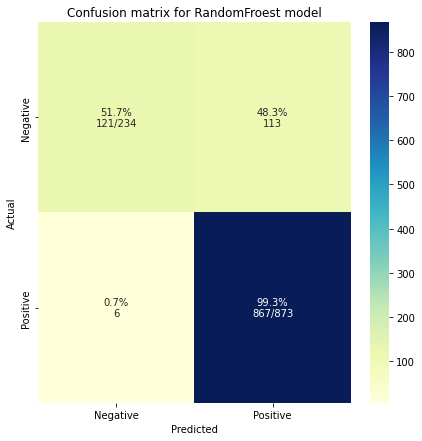

In [84]:
# Showing Confusion Matrix for RandomFroest model
plot_cm(y_test, y_rf_pred, 'Confusion matrix for RandomFroest model', figsize=(7,7))

* model RandomForestClassifier have 86% accuracy with base model. Now we try Gridsearch RandomForestClassifier

### GridsearchCV

In [85]:
# define model RandomForestClassifier with pipeline
rf = RandomForestClassifier()
rf_pipeline = Pipeline([
                     ('model',rf)
                     ])
rf_params = {
    'model__max_depth': np.arange(50,100,10),
    'model__max_features':["auto","log2","sqrt"],
    'model__min_samples_split': np.arange(10,20,10),
    'model__min_samples_leaf': np.arange(20,100,10),
    'model__max_leaf_nodes': np.arange(100,150,10),
}
gsrf = GridSearchCV(rf_pipeline,rf_params,scoring='f1',cv=KFold(n_splits=5,shuffle=True,random_state=42))
gsrf.fit(X_train_tfidf, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impur

In [86]:
gsrf.best_params_

{'model__max_depth': 70,
 'model__max_features': 'sqrt',
 'model__max_leaf_nodes': 120,
 'model__min_samples_leaf': 20,
 'model__min_samples_split': 10}

In [87]:
gsrf_train_predictions_label = gsrf.predict(X_train_tfidf)
gsrf_test_predictions_label = gsrf.predict(X_test_tfidf)
rf_best_estimator = gsrf.best_estimator_.predict(X_test_tfidf)

In [88]:
# print score RandomForestClassifier after gridsearch
print("Accuracy score on train set: %f" % accuracy_score(y_train, gsrf_train_predictions_label))
print("Accuracy score on test set: %f" % accuracy_score(y_test, gsrf_test_predictions_label))

print(classification_report(y_test, rf_best_estimator))

Accuracy score on train set: 0.800813
Accuracy score on test set: 0.789521
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       234
           1       0.79      1.00      0.88       873

    accuracy                           0.79      1107
   macro avg       0.89      0.50      0.45      1107
weighted avg       0.83      0.79      0.70      1107



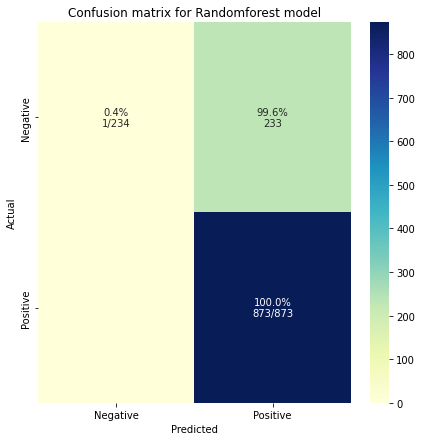

In [89]:
# Showing Confusion Matrix for RandomForestClassifier model
plot_cm(y_test, rf_best_estimator, 'Confusion matrix for Randomforest model', figsize=(7,7))

* After Gridsearch, SupportVectorClassifier model have 79% accuracy, I decide use base model

## Stacking


In [90]:
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lg', LogisticRegression()))
	level0.append(('knc', KNeighborsClassifier()))
	level0.append(('dt', DecisionTreeClassifier()))
	level0.append(('rf', RandomForestClassifier()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
  models = dict()
  models['LogisticRegression'] = LogisticRegression(C=5e1, multi_class='multinomial',n_jobs=4,random_state=17,solver='lbfgs')
  models['KNeighborsClassifier'] = KNeighborsClassifier(metric='minkowski',n_neighbors=12,p=2,weights='distance')
  models['SupportvectorClassifier'] = svm.SVC()
  models['RandomForestClassifier'] = RandomForestClassifier()
  models['stacking'] = get_stacking()
  return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

>LogisticRegression 0.923 (0.013)
>KNeighborsClassifier 0.902 (0.012)
>SupportvectorClassifier 0.895 (0.013)
>RandomForestClassifier 0.885 (0.012)
>stacking 0.928 (0.013)


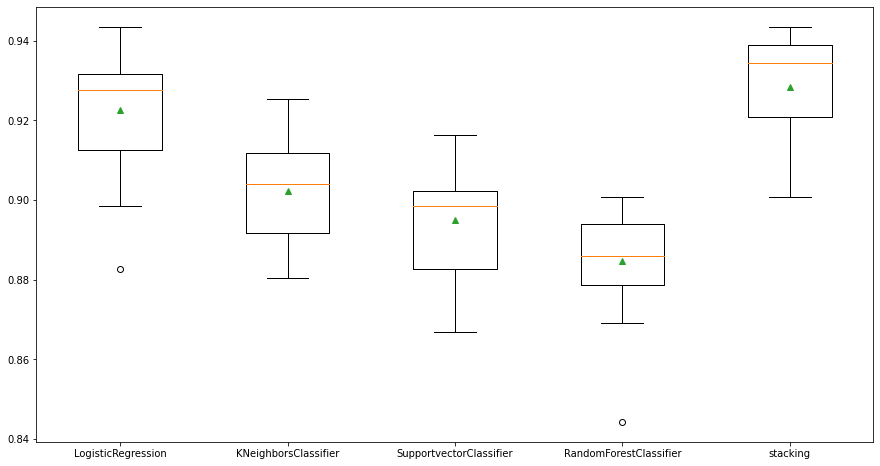

In [91]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train_tfidf, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.figure(figsize=(15,8))
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Save Model

In [ ]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(fine_tune_lg, open(filename, 'wb'))
 
# # load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.fit(X_test_tfidf, y_test)
result = loaded_model.score(X_test_tfidf, y_test)